# Tutorial 8: Building Complex Flows with LangGraph

In this tutorial, we'll explore how to create more complex and sophisticated workflows using LangGraph. We'll build on the concepts introduced in Tutorial 7 and dive into multi-step processes, conditional logic, and error handling.

## Setup

First, let's import the necessary libraries and set up our environment:

In [1]:
import os
from typing import Dict, TypedDict, List
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain.schema import BaseMessage
from langgraph.graph import StateGraph, END

# Initialize the Groq LLM
llm = ChatGroq(
        model_name="llama-3.1-70b-versatile",
        temperature=0.1,
        model_kwargs={"top_p": 0.5, "seed": 1337}
    )

# Define our state structure
class State(TypedDict):
    messages: List[BaseMessage]
    current_step: str
    task_list: List[str]
    error_count: int

## 1. Designing multi-step workflows

Let's create a multi-step task planning and execution workflow. This workflow will:
1. Greet the user and ask for a task
2. Break down the task into subtasks
3. Execute each subtask
4. Provide a summary of the completed task

In [2]:
# Define our graph
workflow = StateGraph(State)

# Define our nodes
def greet_and_ask(state: State) -> State:
    state["messages"].append({"role": "assistant", "content": "Hello! What task can I help you with today?"})
    state["current_step"] = "break_down_task"
    return state

def break_down_task(state: State) -> State:
    task = state["messages"][-1]["content"]
    prompt = ChatPromptTemplate.from_template(
        "Break down the following task into 3-5 subtasks: {task}"
    )
    response = llm(prompt.format_messages(task=task))
    subtasks = response.content.split("\n")
    state["task_list"] = subtasks
    state["messages"].append({"role": "assistant", "content": f"I've broken down your task into the following subtasks:\n{response.content}"})
    state["current_step"] = "execute_subtask"
    return state

def execute_subtask(state: State) -> State:
    if state["task_list"]:
        current_task = state["task_list"].pop(0)
        prompt = ChatPromptTemplate.from_template(
            "Execute the following subtask and provide a brief result: {task}"
        )
        response = llm(prompt.format_messages(task=current_task))
        state["messages"].append({"role": "assistant", "content": f"Completed subtask: {current_task}\nResult: {response.content}"})
        state["current_step"] = "execute_subtask" if state["task_list"] else "summarize"
    else:
        state["current_step"] = "summarize"
    return state

def summarize(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Summarize the completed task and its results based on the following conversation: {conversation}"
    )
    conversation = "\n".join([f"{m['role']}: {m['content']}" for m in state["messages"]])
    response = llm(prompt.format_messages(conversation=conversation))
    state["messages"].append({"role": "assistant", "content": f"Task Summary:\n{response.content}"})
    state["current_step"] = "end"
    return state

# Add nodes to the graph
workflow.add_node("greet_and_ask", greet_and_ask)
workflow.add_node("break_down_task", break_down_task)
workflow.add_node("execute_subtask", execute_subtask)
workflow.add_node("summarize", summarize)

# Define edges
workflow.set_entry_point("greet_and_ask")
workflow.add_edge("greet_and_ask", "break_down_task")
workflow.add_edge("break_down_task", "execute_subtask")
workflow.add_edge("execute_subtask", "execute_subtask")
workflow.add_edge("execute_subtask", "summarize")
workflow.add_edge("summarize", END)

## 2. Handling state and transitions

In the above workflow, we're using the `current_step` key in our state to manage transitions between nodes. This allows us to create more complex flows with multiple possible paths.

## 3. Implementing conditional logic in flows

Now, let's add some conditional logic to our workflow. We'll implement a check to see if the user wants to add more tasks after the initial task is completed.

In [3]:
def check_for_more_tasks(state: State) -> str:
    state["messages"].append({"role": "assistant", "content": "Would you like to add another task? (yes/no)"})
    return "get_user_response"

def get_user_response(state: State) -> str:
    response = state["messages"][-1]["content"].lower()
    if response == "yes":
        return "greet_and_ask"
    elif response == "no":
        return END
    else:
        state["messages"].append({"role": "assistant", "content": "I didn't understand that. Please answer 'yes' or 'no'."})
        return "get_user_response"

# Add new nodes
workflow.add_node("check_for_more_tasks", check_for_more_tasks)
workflow.add_node("get_user_response", get_user_response)

# Update edges
workflow.add_edge("summarize", "check_for_more_tasks")
workflow.add_edge("check_for_more_tasks", "get_user_response")
workflow.add_edge("get_user_response", "greet_and_ask")
workflow.add_edge("get_user_response", END)
workflow.add_edge("get_user_response", "get_user_response")

## 4. Error handling and fallback strategies

Lastly, let's implement some basic error handling in our workflow. We'll add a counter for errors and implement a fallback strategy if too many errors occur.

In [4]:
def handle_error(state: State) -> str:
    state["error_count"] += 1
    if state["error_count"] > 3:
        state["messages"].append({"role": "assistant", "content": "I'm having trouble understanding. Let's start over."})
        state["error_count"] = 0
        return "greet_and_ask"
    else:
        state["messages"].append({"role": "assistant", "content": "I'm sorry, I didn't understand that. Could you please rephrase?"})
        return state["current_step"]

# Add error handling node
workflow.add_node("handle_error", handle_error)

# Update edges to include error handling
for node in ["break_down_task", "execute_subtask", "summarize", "get_user_response"]:
    workflow.add_edge(node, "handle_error")
workflow.add_edge("handle_error", "greet_and_ask")
for node in ["break_down_task", "execute_subtask", "summarize", "get_user_response"]:
    workflow.add_edge("handle_error", node)

# Compile the graph
app = workflow.compile()

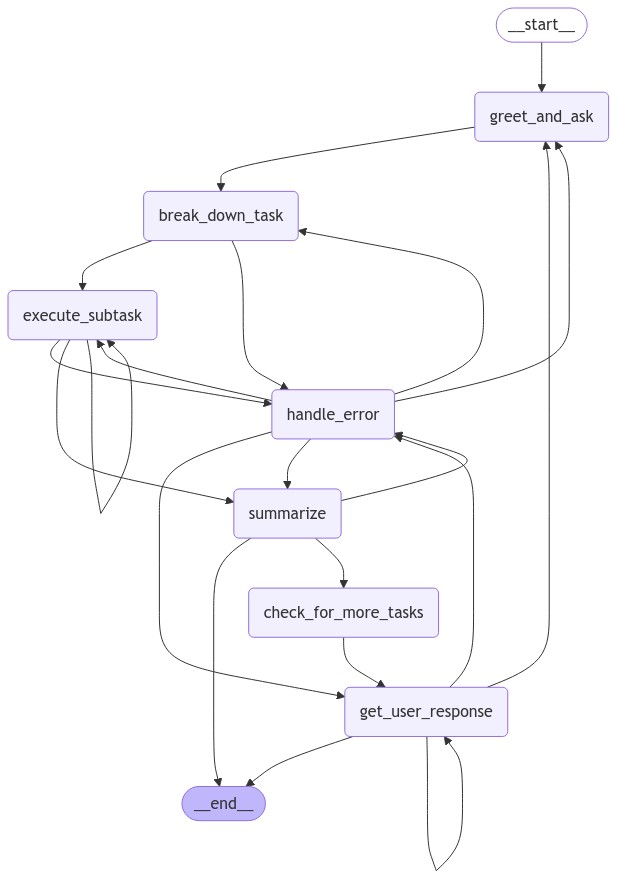

In [8]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

Now, let's test our complex LangGraph flow:

In [6]:
# Initialize the state
initial_state = {"messages": [], "current_step": "", "task_list": [], "error_count": 0}

# Run the graph

for event in app.stream(initial_state):
    for output in event.values():
        if "messages" in output and output["messages"]:
            last_message = output["messages"][-1]
            if last_message["role"] == "assistant":
                print(f"Assistant: {last_message['content']}")
            elif last_message["role"] == "human":
                print(f"Human: {last_message['content']}")
    
        if output["current_step"] in ["break_down_task", "get_user_response"]:
            user_input = input("Your response: ")
            output["messages"].append({"role": "human", "content": user_input})

print("Workflow completed.")

Assistant: Hello! What task can I help you with today?
Assistant: I've broken down your task into the following subtasks:
It seems like there's a typo or unclear instruction in the task "cuiaio+". To provide a helpful response, I'll assume you meant to provide a task, but it's unclear. 

If you could provide more context or clarify the task, I'd be happy to break it down into 3-5 subtasks for you.


InvalidUpdateError: Expected dict, got execute_subtask

## Conclusion

In this tutorial, we've explored how to build complex flows with LangGraph, including:
